In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
#####################################

def load_yelp():
    # Load a csv of floats:
    X = np.genfromtxt("upvote_data.csv", delimiter=",")
    # Load a text file of integers:
    y = np.loadtxt("upvote_labels.txt", dtype=np.int)
    # Load a text file of strings:
    featureNames = open("upvote_features.txt").read().splitlines()

    return X,y,featureNames

def split(data,labels):
    n_train = 4000
    n_valid = 1000
    n_test = 1000
    
    train_d = data[0:n_train,:]
    train_l = labels[0:n_train]
    
    # get rid of outliers
    ind_outlier = np.argmax(train_l)
    #ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
    #ind_outlier = np.argpartition(np.max(np.abs(train_d),axis=1),-10)[-10:]

    mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
    mask_good[ind_outlier] = False
    train_d = train_d[mask_good,:]
    train_l = train_l[mask_good]

    # demean!
    demean= True
    if demean:
        train_d_mean = train_d.mean(axis=0)
        train_l_mean = train_l.mean(axis=0)

        train_d = train_d - train_d_mean[np.newaxis, :]
        train_l = train_l - train_l_mean

    valid_d = data[n_train:n_train+n_valid,:]
    valid_l = labels[n_train:n_train+n_valid]
    
    test_d = data[n_valid::,:]
    test_l = labels[n_valid::]
    
    if demean:

        valid_d = valid_d - train_d_mean[np.newaxis, :]
        valid_l = valid_l - train_l_mean

        test_d = test_d - train_d_mean[np.newaxis, :]
        test_l = test_l - train_l_mean
    
    return train_d,valid_d,test_d,train_l,valid_l,test_l

### lasso!

def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    lambda_vec = []
    sum_y = (1/n)*np.sum(y[:])
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,(y-sum_y))) for k_ind in k_range])
    return lambda_max

def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)

        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])

            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + np.dot(x[:,k],w[k])
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < - lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (-lambda_val < c[k] < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]
        
        print(a)
        print(c)
        weight_diff = w - w_old
        w_old = np.array(w)
        
        # use maximum of weight difference 
        #stop_cond = np.max(weight_diff)
        
        # use mean weight difference 
        
        stop_cond = np.abs(np.mean(weight_diff))
        print('value of lasso run {}'.format(stop_cond))
        #stop_cond_vec.append(stop_cond)
    
    return w

def lasso_loop(x_t,y_t,x_v,y_v):
    w_vec = []
    num_non_zero_vec = []
    lambda_val = lambda_max_func(x_t,y_t)
    lambda_vec = []
    valid_error_vec=[]
    train_error_vec = []
    valid_error_diff = 100
    valid_error_old = 100
    #valid_error_delta = 1e-2
    valid_error_delta = 1e-3

    lambda_ratio = 3/5

    w_init = np.random.random(np.shape(x_t)[1])
    
    while (lambda_val>5e-1):

    #while (valid_error_diff>valid_error_delta):
        print('the value of lambda is {}'.format(lambda_val))
        w = lasso_CD(x_t,y_t,lambda_val,w_init)
        
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        w_vec.append(w)

        w_init = np.array(w)
        
        train_error = error_calc(x_t,y_t,w)
        valid_error = error_calc(x_v,y_v,w)
        
        num_non_zero_vec.append(num_non_zero)
        lambda_vec.append(lambda_val)
        lambda_val = lambda_val*lambda_ratio

        train_error_vec.append(train_error)
        valid_error_vec.append(valid_error)
        valid_error_diff = np.abs(valid_error - valid_error_old)
        valid_error_old = copy.copy(valid_error)
        print('The train error was {}'.format(train_error))

        print('The validation error was {}'.format(valid_error))
        print('The validation error difference was {}'.format(valid_error_diff))
    
    return w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec

def error_calc(x,y,w):
    n = np.shape(y)[0]
    error = (1/n)*np.sum((y-np.dot(x,w))**2)
    return error

def plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec):
   
    ax1= plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,train_error_vec,label='training error')
    plt.plot(lambda_vec,valid_error_vec,label='validation error')
    plt.xlabel(r'$ \lambda $')
    plt.title('Training and Validation error for' +'\n' +'various values of Lambda ')
    plt.ylabel('error')
    plt.legend()
    plt.savefig('hw2_valid_train_error_kaggle_noYmean_noOutlier.png')

    ax2 = plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(lambda_vec,num_non_zero_vec)
    plt.xlabel(r'$ \lambda $')
    plt.ylabel('Number of non zero entries')
    plt.title('Number of non zero entries for ' + '\n' + 'various values of lambda')
    plt.savefig('hw2_nonzero_kaggle_noYmean_noOutlier.png')
    
def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

### part a

In [4]:
# load data
X,y,featureNames = load_yelp()

In [5]:
# split data
train_d,valid_d,test_d,train_l,valid_l,test_l = split(X,y)

(3999,)


(array([  3.09700000e+03,   6.50000000e+02,   1.75000000e+02,
          4.10000000e+01,   1.70000000e+01,   8.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          5.00000000e+00]),
 array([ 0.02232534,  0.09311152,  0.1638977 ,  0.23468387,  0.30547005,
         0.37625623,  0.4470424 ,  0.51782858,  0.58861476,  0.65940093,
         0.73018711]),
 <a list of 10 Patch objects>)

(array([  3.33000000e+03,   4.05000000e+02,   1.66000000e+02,
          4.60000000e+01,   1.30000000e+01,   1.40000000e+01,
          9.00000000e+00,   1.10000000e+01,   4.00000000e+00,
          1.00000000e+00]),
 array([ -1.42285571,   0.97714429,   3.37714429,   5.77714429,
          8.17714429,  10.57714429,  12.97714429,  15.37714429,
         17.77714429,  20.17714429,  22.57714429]),
 <a list of 10 Patch objects>)

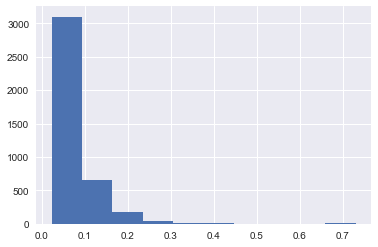

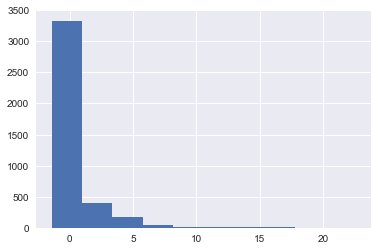

In [70]:

# get rid of outliers
#ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))

outliers_noOutlier = (np.max(np.abs(train_d),axis=1))


print(np.shape(outliers_noOutlier))
plt.figure()
plt.hist(outliers_noOutlier)

plt.figure()
plt.hist(train_l)


In [62]:
np.shape(train_d)
outliers = (np.max(np.abs(train_d),axis=0))
plt.hist(outliers)
outliers[622]

np.shape(train_d)
ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
np.shape(np.max(np.abs(train_d),axis=1))
mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
mask_good[ind_outlier] = False
print('mask shape is ' + str(np.shape(mask_good)))
train_d_noOutlier = np.array(train_d[mask_good,:])
train_l_noOutlier = np.array(train_l[mask_good])
outliers_noOutlier = (np.max(np.abs(train_d_noOutlier),axis=1))
np.shape(outliers_noOutlier)
plt.figure()
plt.hist(outliers_noOutlier)


SyntaxError: invalid syntax (<ipython-input-62-4b10b7a304c7>, line 17)

In [72]:
# np.shape(train_d)
# #ind_outlier = np.argmax(np.max(np.abs(train_d),axis=1))
# ind_outlier = np.argpartition(np.max(np.abs(train_d),axis=1),-10)[-10:]
# mask_good = np.ones((np.shape(train_d)[0],),dtype=bool)
# mask_good[ind_outlier] = False
# np.shape(mask_good)
# train_d_noOut = train_d[mask_good,:]
# train_l_noOut = train_l[mask_good]
# outliers_noOutlier = (np.max(np.abs(train_d_noOut),axis=1))
# np.shape(outliers_noOutlier)
# plt.figure()
# plt.hist(outliers_noOutlier)


In [12]:
w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d,train_l,valid_d,valid_l)

#w_vec,num_non_zero_vec,lambda_vec,valid_error_vec,train_error_vec = lasso_loop(train_d_noOut,train_l_noOut,valid_d,valid_l)

the value of lambda is 146.95618024266457
[ 1.33330932  1.3332527   1.33332372  1.33328313  1.33332894  1.33329976
  1.33328313  1.33328313  1.33328313  1.33328313  1.33328313  1.3332527
  1.33332531  1.33298604  1.3332527   1.33326907  1.33323971  1.3332527
  1.33328313  1.33326907  1.3332527   1.3332527   1.33328313  1.3333315
  1.33333013  1.3332527   1.33328313  1.3332527   1.33331366  1.33326907
  1.33328313  1.33302177  1.3332527   1.33333002  1.33332894  1.33328313
  1.3332527   1.33322273  1.33326907  1.33328313  1.3333286   1.33330565
  1.33328313  1.3332527   1.33328313  1.3333092   1.33318592  1.33328313
  1.33328423  1.32933286  1.33328313  1.33332717  1.33326907  1.33326907
  1.3332527   1.3333013   1.33328313  1.33328313  1.33330028  1.33328313
  1.33328313  1.3332527   1.33326907  1.3332527   1.33328313  1.3332527
  1.33332545  1.33328313  1.33322177  1.33328313  1.33328384  1.33332539
  1.33327555  1.33328313  1.3332527   1.33333238  1.33328313  1.3332527
  1.33328313  

KeyboardInterrupt: 

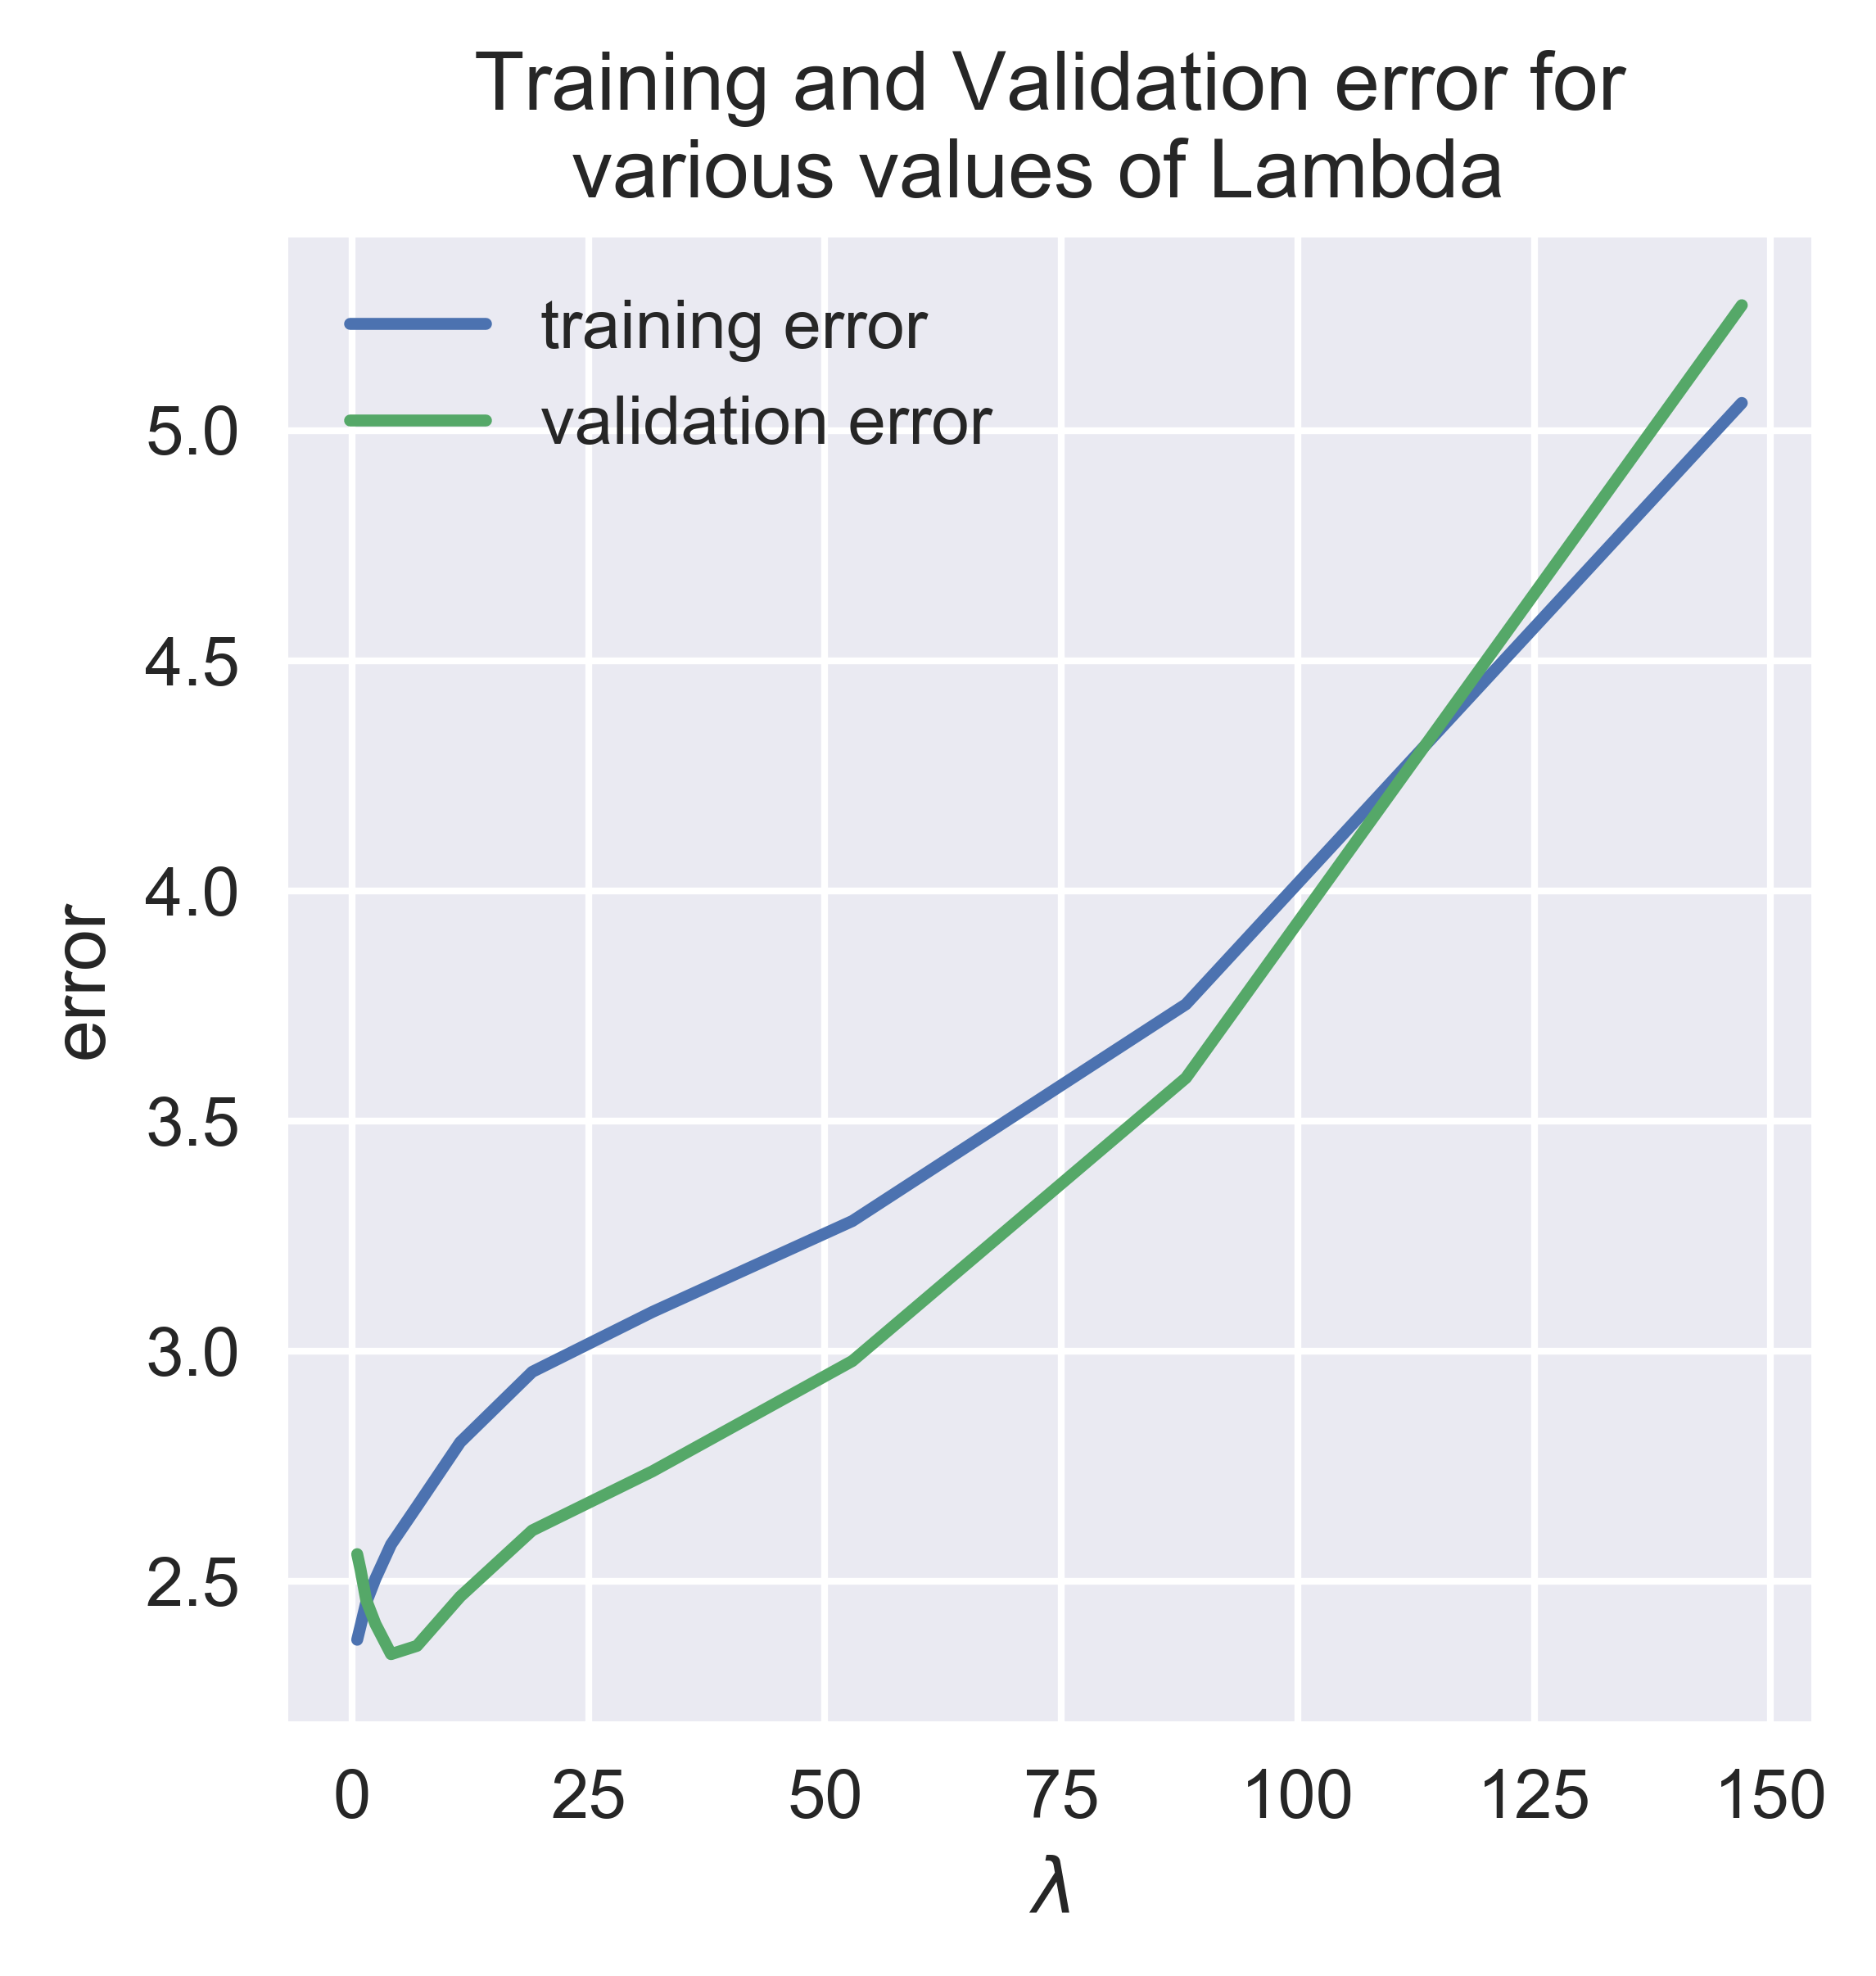

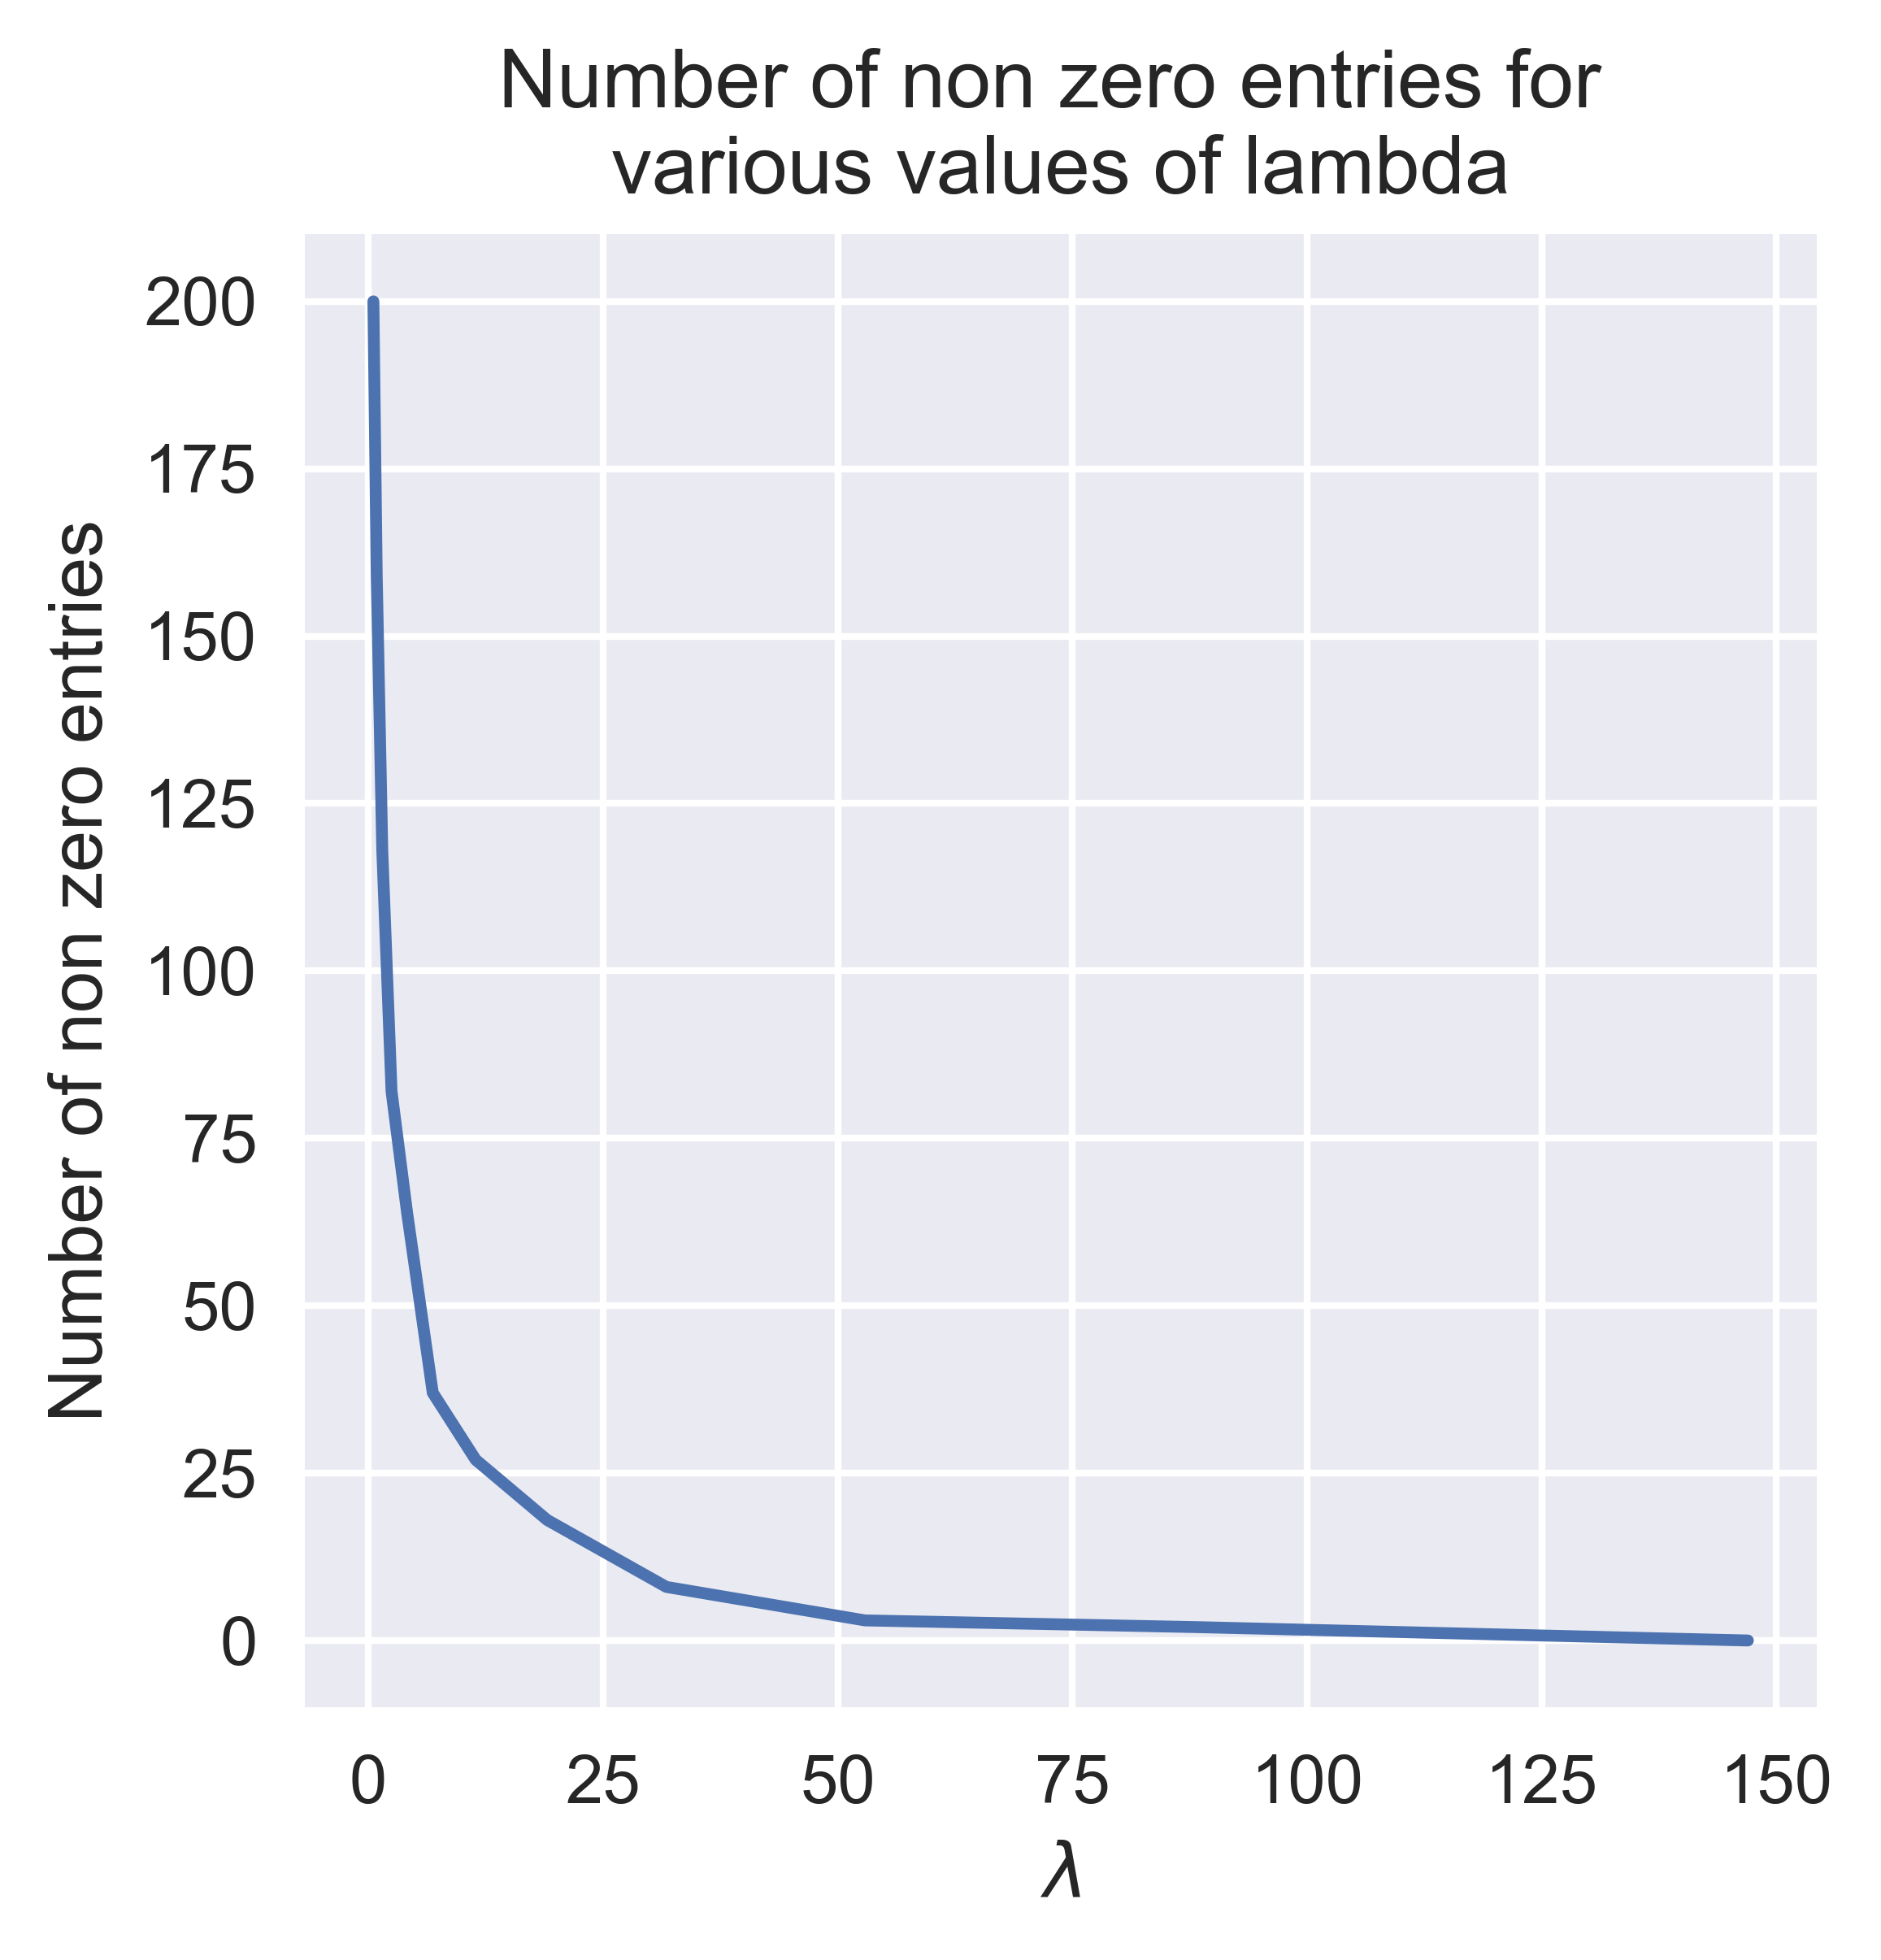

In [7]:
plot_valid_train(train_error_vec,valid_error_vec,num_non_zero_vec,lambda_vec)

### part b

In [8]:
# lambda optimal
ind_valid_min = np.array(np.argmin(valid_error_vec))
lambda_opt = lambda_vec[ind_valid_min]
w_vec_array = np.array(w_vec)
w_best = w_vec_array[ind_valid_min,:]

test_error = error_calc(test_d,test_l,w_best)
print('The test error is {}'.format(test_error))

ind_valid_min
np.shape(ind_valid_min)
np.shape(w_vec)
type(ind_valid_min)
type(w_vec)

The test error is 4.230945930461277


array(7)

()

(12, 1000)

numpy.ndarray

list

### part c

In [9]:
featureNamesArray = np.array(featureNames)

In [10]:
inds_top10 = np.argpartition(np.abs(w_best), -10)[-10:]

top10_weight = w_best[inds_top10]
top10_feat = featureNamesArray[inds_top10]
zipped_top10 = list(zip(top10_feat,top10_weight))

print('The top ten features and their weights are {}'.format(zipped_top10))

The top ten features and their weights are [('sq(ReviewNumWords*UserNumReviews)', -9.6636100728425181), ('sq(ReviewDate*UserNumReviews)', -11.024925851796405), ('sqrt(UserCoolVotes*BusinessNumStars)', 11.761200121908788), ('log(ReviewNumCharacters*UserUsefulVotes)', 12.157750996719836), ('sqrt(UserFunnyVotes*InPhoenix)', 13.528546977323584), ('sq(UserFunnyVotes*BusinessNumStars)', 14.563022696897129), ('ReviewDate*UserNumReviews', -21.572444905495104), ('sqrt(ReviewNumCharacters*UserFunnyVotes)', 49.621023997969004), ('UserUsefulVotes*InScottsdale', 14.879893367720285), ('sqrt(ReviewNumCharacters*UserCoolVotes)', 19.32273016272767)]


### scratch section

In [ ]:
lambda_opt